# L-Type Calcium Channel

Thus far, only data where the activity is attributed to interaction with a single protein, such as CACNA1C ('Voltage-gated L-type calcium channel alpha-1C subunit'), has been considered. This is done to simplify interpretation and to try and avoid introducing noise from _e.g._ different SAR trends for different isoforms.
   
However, in the case of L-Type Calcium Channel (LTCC), the amount of data available for CACNA1C, the primary isoform of interest, is fairly small. As this is an important target for cardiac safety modelling, it is of interest to examine the effects of relaxing the single-isoform requirement. ChEMBL also includes data for 'protein families': here, either the precise isoform responsible for the activity is not clear and/or the activity is believed to be due to all members of a family. 

Thus, here we examine data labelled 'Voltage-gated L-type calcium channel' as well as data on all the various L-type calcium channel isoforms available in ChEMBL (CACNA1S and CACNA1D).

In addition, data for species other than Human and Rat has been included. Rabbit and Guinea Pig have been important in cardiovascular studies in a way they are not in pharmacology and toxicology in general, and there has been a considerable amount of data generated for these species. Thus, including them could be vital for capturing _e.g._ the full diversity of chemical structures tested in cardiovasular models. It is hoped that this increased coverage will compensate for the risk of increased 'noise' that could accompany increasing the number of species considered. Note that there are some issues around the use of data from these less typical species in ChEMBL: they are discussed in more detail [below](#target_definition).

See the notebook '[LTCC_Report](LTCC_Report.ipynb)' for the same data broken out by document and assay for inspection.

In [1]:
from itertools import chain, combinations

from math import ceil

from scipy import stats

from chembl_webresource_client import CompoundResource

In [2]:
pd.set_option('display.multi_sparse', False)

In [3]:
# pActivity column to use...

activity_col = 'pchembl_value'

# Compound column (for aggregation)...

cmpd_col = 'parent_cmpd_chemblid'

# More significant species...

main_species = ['Guinea Pig', 'Human', 'Pig', 'Rabbit', 'Rat']

In [4]:
# Get means, maxes and counts (for actives only)...

def f(x):
    
    data = x[activity_col]
        
    return pd.Series([data.mean(), data.max(), data.size], index=['mean', 'max', 'n'])

### Load data

See the notebook [Data](Data.ipynb) for further details.

In [5]:
# Load curve data (IC50, Ki, Kd etc)...

data = pd.read_pickle('data.pkl')

data.shape

(1317, 30)

In [6]:
HTML(data.head(2).to_html())

,target_chemblid,pref_name,target_type,organism,species,tissue,relationship_type,assay_chemblid,description,assay_organism,parent_cmpd_chemblid,compound_class,standard_type,standard_relation,standard_value,standard_units,pchembl_value,activity_comment,data_validity_comment,potential_duplicate,cmpd_chemblid,compound_key,published_type,published_relation,published_value,published_units,doc_chemblid,pubmed_id,reference,active
0,CHEMBL1940,Voltage-gated L-type calcium channel alpha-1C subunit,SINGLE PROTEIN,Homo sapiens,Cat,Heart,H,CHEMBL656260,Inhibition of (-)-[3H]- D-888 binding to L-type calcium channels in kitten heart ventricle membranes,Felis catus,CHEMBL138302,PAA,IC50,=,260,nM,6.59,None,None,NaN,CHEMBL138302,2d,IC50,=,0.26,uM,CHEMBL1127038,8474099,"J. Med. Chem., v. 36, p. 439 (1993)",1
1,CHEMBL1940,Voltage-gated L-type calcium channel alpha-1C subunit,SINGLE PROTEIN,Homo sapiens,Cat,Heart,H,CHEMBL656260,Inhibition of (-)-[3H]- D-888 binding to L-type calcium channels in kitten heart ventricle membranes,Felis catus,CHEMBL138302,PAA,IC50,=,390,nM,6.41,None,None,NaN,CHEMBL138302,2a,IC50,=,0.39,uM,CHEMBL1127038,8474099,"J. Med. Chem., v. 36, p. 439 (1993)",1


#### Some basic counts

In [7]:
print("""
Number of data records:                                     {:4d}
Number of unique parent compounds:                          {:4d}
Number of unique active parent compounds:                   {:4d}
Number of unique active parent compounds for major species: {:4d}
""".format(
  data.shape[0]
, data[cmpd_col].drop_duplicates().size
, data.query("active == 1")[cmpd_col].drop_duplicates().size
, data.query("active == 1 and species in @main_species")[cmpd_col].drop_duplicates().size
))


Number of data records:                                     1317
Number of unique parent compounds:                           897
Number of unique active parent compounds:                    653
Number of unique active parent compounds for major species:  647



<a name="target_definition"></a>
### Note on Target definition

Historically, gene/protein sequence coverage for species other than Human, Mouse and Rat has been somewhat patchy. As ChEMBL has required a protein sequence be associated with all molecular targets, when a sequence has _not_ been available the 'organism' column in the target dictionary has been set to a related species for which a sequence was available and a 'relationship' flag set to indicate that the sequence is in fact a homologue.

Essentially, this means that for species of interest here such as Guinea Pig and Rabbit, use of the `organism` column in the target dictionary can be problematic.

To get round this, the Target ChEMBL ID is not used here. Instead we use a combination of the local species assignment (`species`) and the preferred name (`pref_name`) from the target dictionary to uniquely identity a target. The species assignement was done using a combination of `organism` from the `target_dictionary` table, the `assay_organism` from the `assays` table and description and the `description` from the `asays` table. Futher details are in the '[Data](Data.ipynb)' notebook.

In [8]:
data[['organism', 'pref_name', 'target_chemblid', 'species']].drop_duplicates().sort(['organism', 'pref_name', 'species'])

,organism,pref_name,target_chemblid,species
16,Homo sapiens,Voltage-gated L-type calcium channel,CHEMBL2095229,Guinea Pig
125,Homo sapiens,Voltage-gated L-type calcium channel,CHEMBL2095229,Human
484,Homo sapiens,Voltage-gated L-type calcium channel,CHEMBL2095229,Rabbit
0,Homo sapiens,Voltage-gated L-type calcium channel alpha-1C subunit,CHEMBL1940,Cat
12,Homo sapiens,Voltage-gated L-type calcium channel alpha-1C subunit,CHEMBL1940,Cow
19,Homo sapiens,Voltage-gated L-type calcium channel alpha-1C subunit,CHEMBL1940,Guinea Pig
136,Homo sapiens,Voltage-gated L-type calcium channel alpha-1C subunit,CHEMBL1940,Human
255,Homo sapiens,Voltage-gated L-type calcium channel alpha-1C subunit,CHEMBL1940,Pig
9,Homo sapiens,Voltage-gated L-type calcium channel alpha-1D subunit,CHEMBL4138,Cow
144,Homo sapiens,Voltage-gated L-type calcium channel alpha-1D subunit,CHEMBL4138,Human


###  Counts by compound class

See [Compound_Classes](Compound_classes.ipynb) notebook for details of class assignment.

In [9]:
# Aggregation column...

aggr_col = 'compound_class'

In [10]:
# Counts of unique parent compounds by compound class (all)...

data[[cmpd_col, aggr_col]].drop_duplicates()[aggr_col].value_counts()

       475
DHP    337
BTZ     82
PAA      3
dtype: int64

In [11]:
# Counts of unique, active parent compounds by compound class for major species...

data.query("active == 1 and species in @main_species")[[cmpd_col, aggr_col]].drop_duplicates()[aggr_col].value_counts()

       316
DHP    266
BTZ     64
PAA      1
dtype: int64

In [12]:
# Calculate mean activities for active parent compounds for major species...

means = data.query("active == 1 and species in @main_species")[[cmpd_col, aggr_col, activity_col]].groupby([cmpd_col, aggr_col]).apply(f).reset_index()

means.shape

(647, 5)

In [13]:
# Parent compounds with most records...

means.sort('n', ascending=False).head()

,parent_cmpd_chemblid,compound_class,mean,max,n
238,CHEMBL23,BTZ,7.306154,7.80,13
194,CHEMBL193,DHP,8.526667,9.40,12
367,CHEMBL277363,,9.097778,9.80,9
217,CHEMBL2109962,DHP,6.926250,8.10,8
365,CHEMBL275195,,6.960000,7.25,6


In [14]:
# Boxplots: all actives, means and maxes...

def do_boxplots():

    categories = means[aggr_col].drop_duplicates().tolist()

    d1  = [data.query("{} == @x and active == 1".format(aggr_col))[activity_col].tolist() for x in categories]
    d2  = [means.query("{} == @x".format(aggr_col))['mean'].tolist() for x in categories]
    d3  = [means.query("{} == @x".format(aggr_col))['max'].tolist() for x in categories]

    fig = plt.figure(figsize=(30, 6))

    fig.suptitle("Box plots of active values")

    ax1, ax2, ax3 = fig.add_subplot(1,3,1), fig.add_subplot(1,3,2), fig.add_subplot(1,3,3)

    ax1.set_title("All values"); ax2.set_title("Mean values"); ax3.set_title("Maximum values")

    plot1, plot2, plot3 = ax1.boxplot(d1, labels=categories), ax2.boxplot(d2, labels=categories), ax3.boxplot(d3, labels=categories)

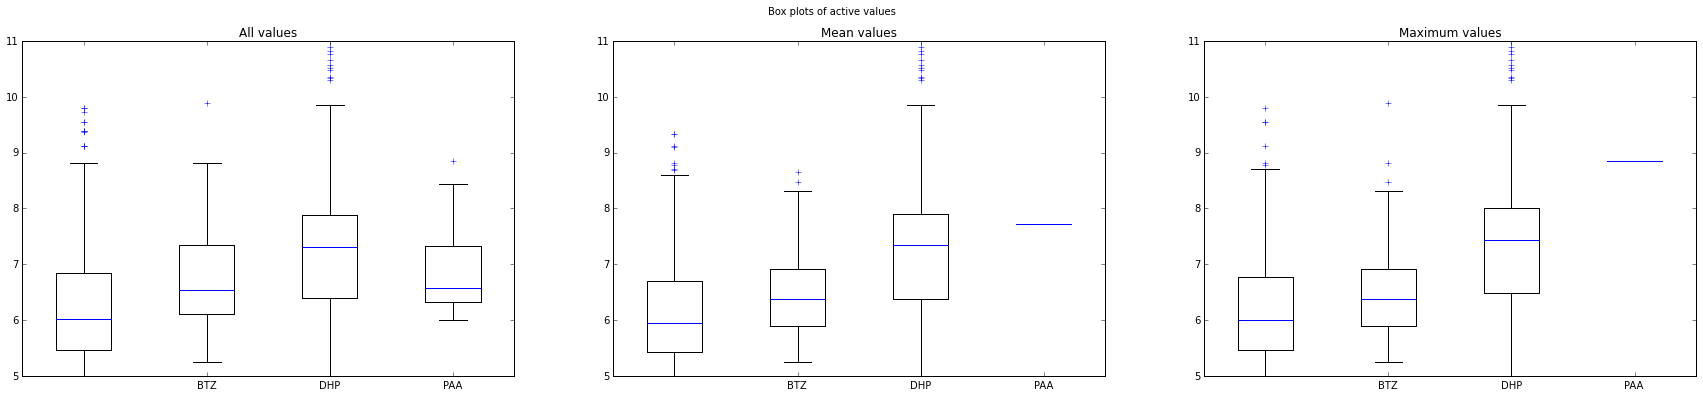

In [15]:
# Not much difference between the plots...

do_boxplots()

### Counts by species

See [Data](Data.ipynb) notebook for details of species assignment.

In [16]:
# Aggregation column...

aggr_col = 'species'

In [17]:
# Counts of unique parent compounds by species (all)...

data[[cmpd_col, aggr_col]].drop_duplicates()[aggr_col].value_counts()

Rat           614
Rabbit        263
Human         121
Guinea Pig     98
Pig            12
Cow             5
Cat             3
Other           1
dtype: int64

In [18]:
# Counts of unique, active parent compounds by species for major species...

data.query("active == 1")[[cmpd_col, aggr_col]].drop_duplicates()[aggr_col].value_counts()

Rat           462
Rabbit        179
Guinea Pig     88
Human          39
Pig            12
Cow             4
Cat             3
dtype: int64

In [19]:
# Calculate means for active parent compounds for major species...

means = data.query("active == 1 and species in @main_species")[[cmpd_col, aggr_col, activity_col]].groupby([cmpd_col, aggr_col]).apply(f).reset_index()

means.shape

(780, 5)

In [20]:
# means.sort('n', ascending=False).head()

In [21]:
# means.query("n > 1").shape

In [22]:
# means[aggr_col].value_counts().to_frame('count').loc[species]

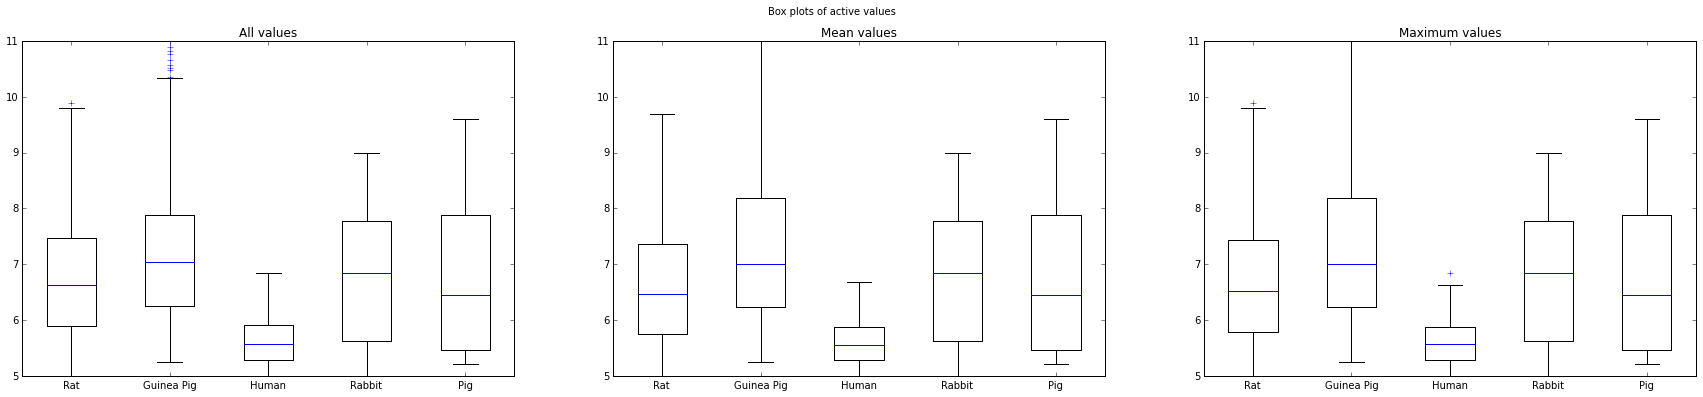

In [23]:
# Again, not much difference between the plots...

do_boxplots()

### Counts by target

Recall that, in this context, 'target' is not a ChEMBL Target ID but rather a combination of a species (determined from the assay description) and the target name (the 'pref_name').

This is due to some historical limitations in the organism assignment for species such as Guinea Pig and Rabbit, for which gene/protein sequences have not been so readily available as they are for Human and Rat. 

In [24]:
# Aggregation columns...

aggr_cols = ['species', 'pref_name']

In [25]:
# Calculate means (and maxes and counts) for active parent compounds for targets...

means = data.query("active == 1 and species in @main_species")[[cmpd_col] + aggr_cols + [activity_col]].groupby([cmpd_col] + aggr_cols).apply(f)

means.reset_index(level=[1,2], inplace=True)

means.shape

(831, 5)

In [26]:
# Get counts of distinct active parent compounds for targets...

counts = pd.crosstab(means[aggr_cols[0]], means[aggr_cols[1]])

counts = counts[counts > 0].T.unstack().dropna().reset_index()

counts.columns.values[-1] = 'count'

counts

,species,pref_name,count
0,Guinea Pig,Voltage-gated L-type calcium channel,25
1,Guinea Pig,Voltage-gated L-type calcium channel alpha-1C subunit,34
2,Guinea Pig,Voltage-gated L-type calcium channel alpha-1S subunit,37
3,Human,Voltage-gated L-type calcium channel,23
4,Human,Voltage-gated L-type calcium channel alpha-1C subunit,12
5,Human,Voltage-gated L-type calcium channel alpha-1D subunit,4
6,Pig,Voltage-gated L-type calcium channel alpha-1C subunit,12
7,Rabbit,Voltage-gated L-type calcium channel,26
8,Rabbit,Voltage-gated L-type calcium channel alpha-1C subunit,153
9,Rat,Voltage-gated L-type calcium channel,178


### Boxplots of mean pActivities by target

Only the means are plotted here as the maximal values and unsummarised value sdo not appear to add much.

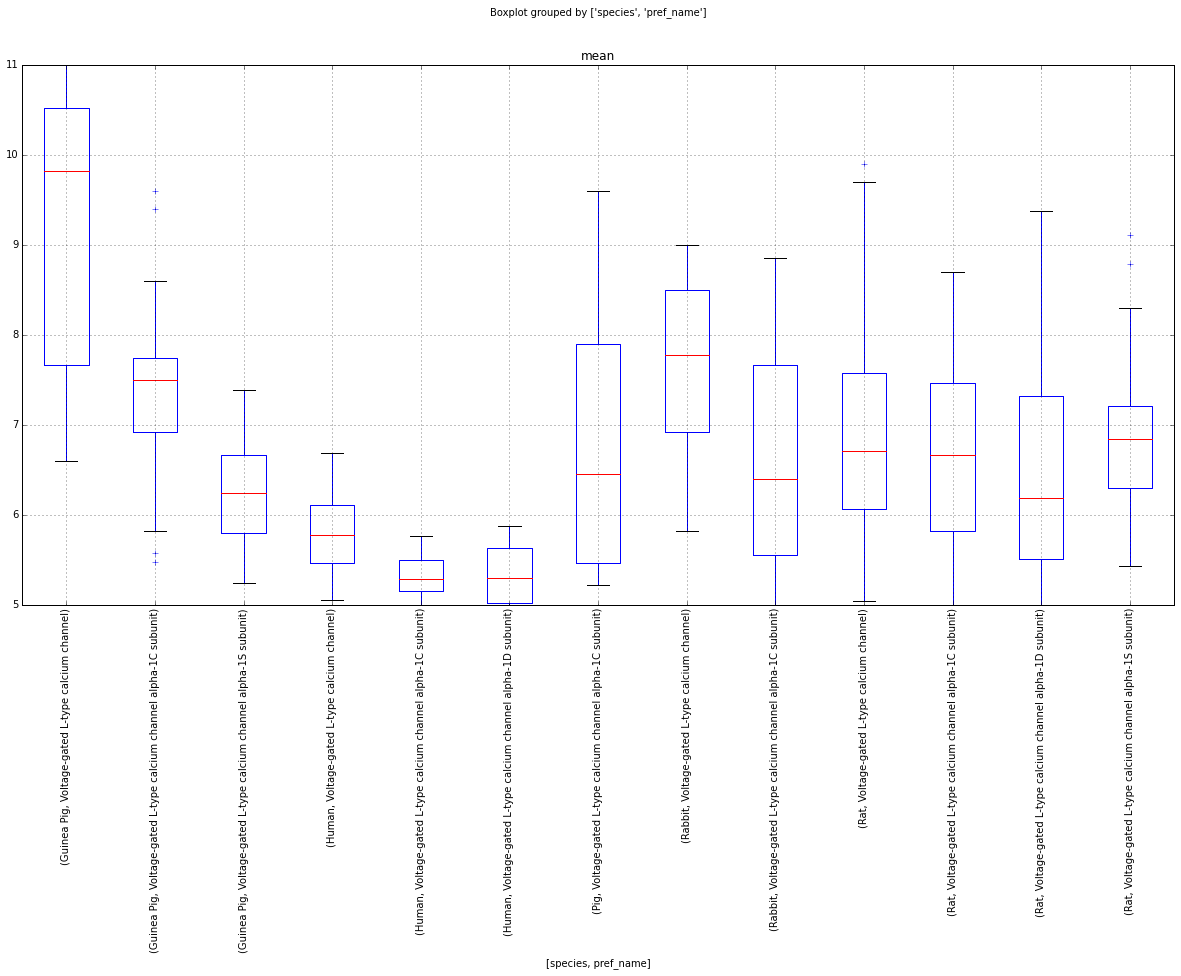

In [27]:
means.boxplot(column='mean', by=aggr_cols, figsize=(20, 10), rot=90)

### Differences in activities between tissue types

Inspection of the boxplots above suggest that for Guinea Pig and Rabbit, the mean pActivities with the preferred name 'Voltage-gated L-type calcium channel' are higher than those labelled with a particular isoform such as 'Voltage-gated L-type calcium channel alpha-1C subunit'.

This might also to be the case for Human, but seems not to be so for Rat.

Such systematic differences in activity profiles could clearly have implications for data pooling strategies. 

Note that only the specific isoform 'Voltage-gated L-type calcium channel alpha-1C subunit' is considered alongside the non-specific 'Voltage-gated L-type calcium channel', as the others do not occur for all species of interest...

In [28]:
# Target names...

pref_names = ['Voltage-gated L-type calcium channel', 'Voltage-gated L-type calcium channel alpha-1C subunit']

In [29]:
# Perform intra-species t-tests...

print("{:10s} : {}\n".format('species', 'p-value'))

for species in ['Guinea Pig', 'Human', 'Rabbit', 'Rat']:
    
    subsets = [means.query("species == @species and pref_name == @x")['mean'] for x in pref_names]

    print("{:10s} : {:.7f}".format(species, stats.ttest_ind(*subsets)[1]))

species    : p-value

Guinea Pig : 0.0000001
Human      : 0.0019579
Rabbit     : 0.0000054
Rat        : 0.0693203


The t-test does suggest that there is indeed a systematic difference in the activities labelled 'Voltage-gated L-type calcium channel' _vs._ the more-specific 'Voltage-gated L-type calcium channel alpha-1C subunit' for Guinea Pig and Rabbit, but not for Rat.

Note that the normality of some data subsets is questionable: however, the p-values for Guinea Pig and Rabbit are sufficiently small that the conclusions there are not in doubt.

One factor that might be important here is the tissue type in which an experiment was conducted. For example, there is some literature suggesting that different splice variants of CACNA1C predominate in cardiac and smooth muscle, which might conceivably lead to SAR differences.

To investigate this issue, tissue types were assigned based on the assay descriptions, where possible (see the notebook '[Tissues](Tissues.ipynb)' for further details). This information is not typically available for the Human data, so that species in excluded from the analysis below. 

Inspection of the number of distinct active parent compounds available for different tissue types for Guinea Pig, Rabbit and Rat do indeed show some interesting differences...

In [30]:
html = ''

for species in ['Guinea Pig', 'Rabbit', 'Rat']:

    html += '<h3>{}</h3>'.format(species)

    for pref_name in pref_names:

        subset = data.query("species == @species and pref_name == @pref_name and active == 1")

        html += '<h4>{}</h4>'.format(pref_name) + subset['tissue'].value_counts().to_frame('count').to_html()
    
HTML(html)

,count
Smooth Muscle,25
,count
Heart,35
,count
Smooth Muscle,26
,count
,120
Heart,18
Smooth Muscle,16
,count


For Guinea Pig, all the data labelled 'Voltage-gated L-type calcium channel' (with tissue information available) are from Smooth Muscle, and all those labelled 'Voltage-gated L-type calcium channel alpha-1C subunit' are from Heart. This suggests the possibility of tissue-specific SARs, despite CACNA1C being the predominant isoform in both tissue types. If these differences were real, there could be various causes: the possiblility that different splice variants predominate in different tissues has been mentioned; however, the literature also suggests that differences in the electrochemical environments in the two tissues could also be a factor.
 
Note that this analysis does not control for various possible sources of variability, such as the chemotypes being tested; this is discussed briefly [below](#guinea_pig_chemotypes).

For Rabbit, the data labelled 'Voltage-gated L-type calcium channel' is again all from Smooth Muscle, whereas that labelled 'Voltage-gated L-type calcium channel alpha-1C subunit' is a mixture of Heart and Smooth Muscle. This might account for there being a significant difference, but for it being somewhat smaller than for Guinea Pig.

For Rat, by contrast, the bulk of the data labelled 'Voltage-gated L-type calcium channel' is from Brain tissue, and therefore presumably primarily of the CACNA1D subtype rather than CACNA1C. There seems to be little difference in mean activities between the various Rat targets; the reasons for this difference to the other species are not known.

Note also that the reasons for the differences in the assignment of targets to assays for different tissues is not currently clear. However, at least some of this data seems to have been added to ChEMBL fairly early on, and therefore may have been processed by a differet CRO than was used subsequently. 

As well as the intra-species differences seen for some species, there may be per-isotype differences between species. However, this does not seem so clear cut and will not be pursued further at present.

<a name='guinea_pig_chemotypes'></a>

### Guinea Pig Chemotypes

It was noted above that one of the sources of the apparent difference in activities between Guinea Pig targets 'Voltage-gated L-type calcium channel' and 'Voltage-gated L-type calcium channel alpha-1C subunit' could be the different tissue used in the assays. While this could conceivably be due to a general difference in the sensitivity of different tissue to L-type Calcium Channel antagonists, it might more plausibly be the case that different classes of blocker might have different effects in different tissues. Indeed, this distinction is recognized clinically, with the DHPs being used primarily to lower blood pressure due to their relative selectivity for vascular tissue, while the other classes such as the PAAs and BZPs being used mainly for _e.g._ treating arrythmias due to their relative selectivity for the heart.

Examining the distriubution of compound classes in the Guinea Pig data discussed above shows that all the data for 'Voltage-gated L-type calcium channel' (which was all generated in Smooth Muscle tissue) are for DHPs, while the data for 'Voltage-gated L-type calcium channel alpha-1C subunit' (which was all generated in Heart tissue), while predominantly involving DHPs, also involves some other chemotypes...

In [31]:
# Subset data records and count by 'pref_name' and 'compound_class'...

species, pref_names = 'Guinea Pig', ['Voltage-gated L-type calcium channel', 'Voltage-gated L-type calcium channel alpha-1C subunit']

subset = data.query("species == @species and pref_name in @pref_names").replace('', 'None')

pd.crosstab(subset['pref_name'], subset['compound_class'])

compound_class,BTZ,DHP,None
pref_name,,,
Voltage-gated L-type calcium channel,0,26,0
Voltage-gated L-type calcium channel alpha-1C subunit,3,31,6


The identity of the unclassified compounds is of interest, so extract them for inspection...

In [32]:
subset['image'] = subset['parent_cmpd_chemblid'].apply(lambda x: '<img src="https://www.ebi.ac.uk/chembl/api/data/image/{}?dimensions=250">'.format(x))

HTML(subset.query("compound_class == 'None'")[['image', 'parent_cmpd_chemblid', 'compound_key', 'published_type', 'published_relation', 'published_value', 'published_units', 'pchembl_value', 'doc_chemblid', 'reference']].to_html())

,image,parent_cmpd_chemblid,compound_key,published_type,published_relation,published_value,published_units,pchembl_value,doc_chemblid,reference
70,,CHEMBL290092,8q,Kd,=,105.0,nM,6.98,CHEMBL1125160,"J. Med. Chem., v. 33, p. 1510 (1990)"
98,,CHEMBL36090,8r,Kd,=,3400.0,nM,5.47,CHEMBL1125160,"J. Med. Chem., v. 33, p. 1510 (1990)"
99,,CHEMBL36384,8c,Kd,=,35.0,nM,7.46,CHEMBL1125160,"J. Med. Chem., v. 33, p. 1510 (1990)"
100,,CHEMBL36673,8j,Kd,=,120.0,nM,6.92,CHEMBL1125160,"J. Med. Chem., v. 33, p. 1510 (1990)"
103,,CHEMBL39376,8k,Kd,=,12.0,nM,7.92,CHEMBL1125160,"J. Med. Chem., v. 33, p. 1510 (1990)"
104,,CHEMBL39684,8l,Kd,=,2.6,nM,8.59,CHEMBL1125160,"J. Med. Chem., v. 33, p. 1510 (1990)"


Note that all of these compounds come from one document [CHEMBL1125160](https://www.ebi.ac.uk/chembl/doc/inspect/CHEMBL1125160), and look suspiciously like 'oxidised' pyrimidine analogues of the DHPs. 

Inspection of the document confirms that these are in fact dihydropyrimidine DPH analogues that have been transcribed incorrectly...

In [33]:
# CHEMBL1125160...

HTML('<iframe src="http://pubs.acs.org/doi/pdf/10.1021/jm00167a035" height=500 width=800/>')

Thus, almost all the compounds involved here are DHPs, and compound class is thus less likely to be an explanation for the apparent difference in activities between the two tissue type. While there may well be SAR differences between DHP subtypes, that is beyond the scope of this exercise.

This also illustrates the value of checking the data in detail before drawing any conclusions.

### Compare data for pairs of targets

Here, compound-level data for pairs of targets are compared. Each data point is the averaged pActivity data for a parent compound, ignoring modifiers (_e.g._ '<').

This is a crude way to inspect the data (and can lead to problems, as is illustrated below). Nevertheless, it should give a useful approximate overview of the data.

In [34]:
# Get means, maxes and counts for all parent compounds (i.e. not just actives)...

means = data.query("species in @main_species")[[cmpd_col] + aggr_cols + [activity_col]].groupby([cmpd_col] + aggr_cols).apply(f) # NB Not filtering on activity

In [35]:
# Reformat data...

means = means.drop(['max', 'n'], axis=1).reset_index().set_index([cmpd_col] + aggr_cols).unstack(aggr_cols)

means.columns = means.columns.droplevel()

means = means[sorted(means.columns.values)] # Put columns is alphabetical order

In [36]:
# Find pairs of targets which have at least a minimum number of parent compounds in common...

pair_threshold = 5

target_pairs = pd.DataFrame(
    ((x, means[x].count(), y, means[y].count(), n, d.corr().iloc[0, 1]) for x, y, n, d in
        ((x, y, d.shape[0], d) for x, y, d in
            ((x, y, means[[x, y]].dropna(how='any')) for x, y in
                combinations(means.columns.values, 2)
            )
        )
    if n > pair_threshold)
    , columns=['target_1', 'n_1', 'target_2', 'n_2', 'n', 'r']
).sort(['r', 'n'], ascending=False).reset_index(drop=True)

target_pairs

,target_1,n_1,target_2,n_2,n,r
0,"(Rat, Voltage-gated L-type calcium channel)",178,"(Rat, Voltage-gated L-type calcium channel alpha-1D subunit)",240,22,0.997030
1,"(Guinea Pig, Voltage-gated L-type calcium channel)",25,"(Guinea Pig, Voltage-gated L-type calcium channel alpha-1C subunit)",37,8,0.987964
2,"(Rabbit, Voltage-gated L-type calcium channel alpha-1C subunit)",208,"(Rat, Voltage-gated L-type calcium channel alpha-1D subunit)",240,170,0.929745
3,"(Guinea Pig, Voltage-gated L-type calcium channel alpha-1C subunit)",37,"(Rat, Voltage-gated L-type calcium channel alpha-1C subunit)",90,9,0.906448
4,"(Rat, Voltage-gated L-type calcium channel)",178,"(Rat, Voltage-gated L-type calcium channel alpha-1C subunit)",90,21,0.584366
5,"(Rat, Voltage-gated L-type calcium channel alpha-1C subunit)",90,"(Rat, Voltage-gated L-type calcium channel alpha-1D subunit)",240,6,0.480913


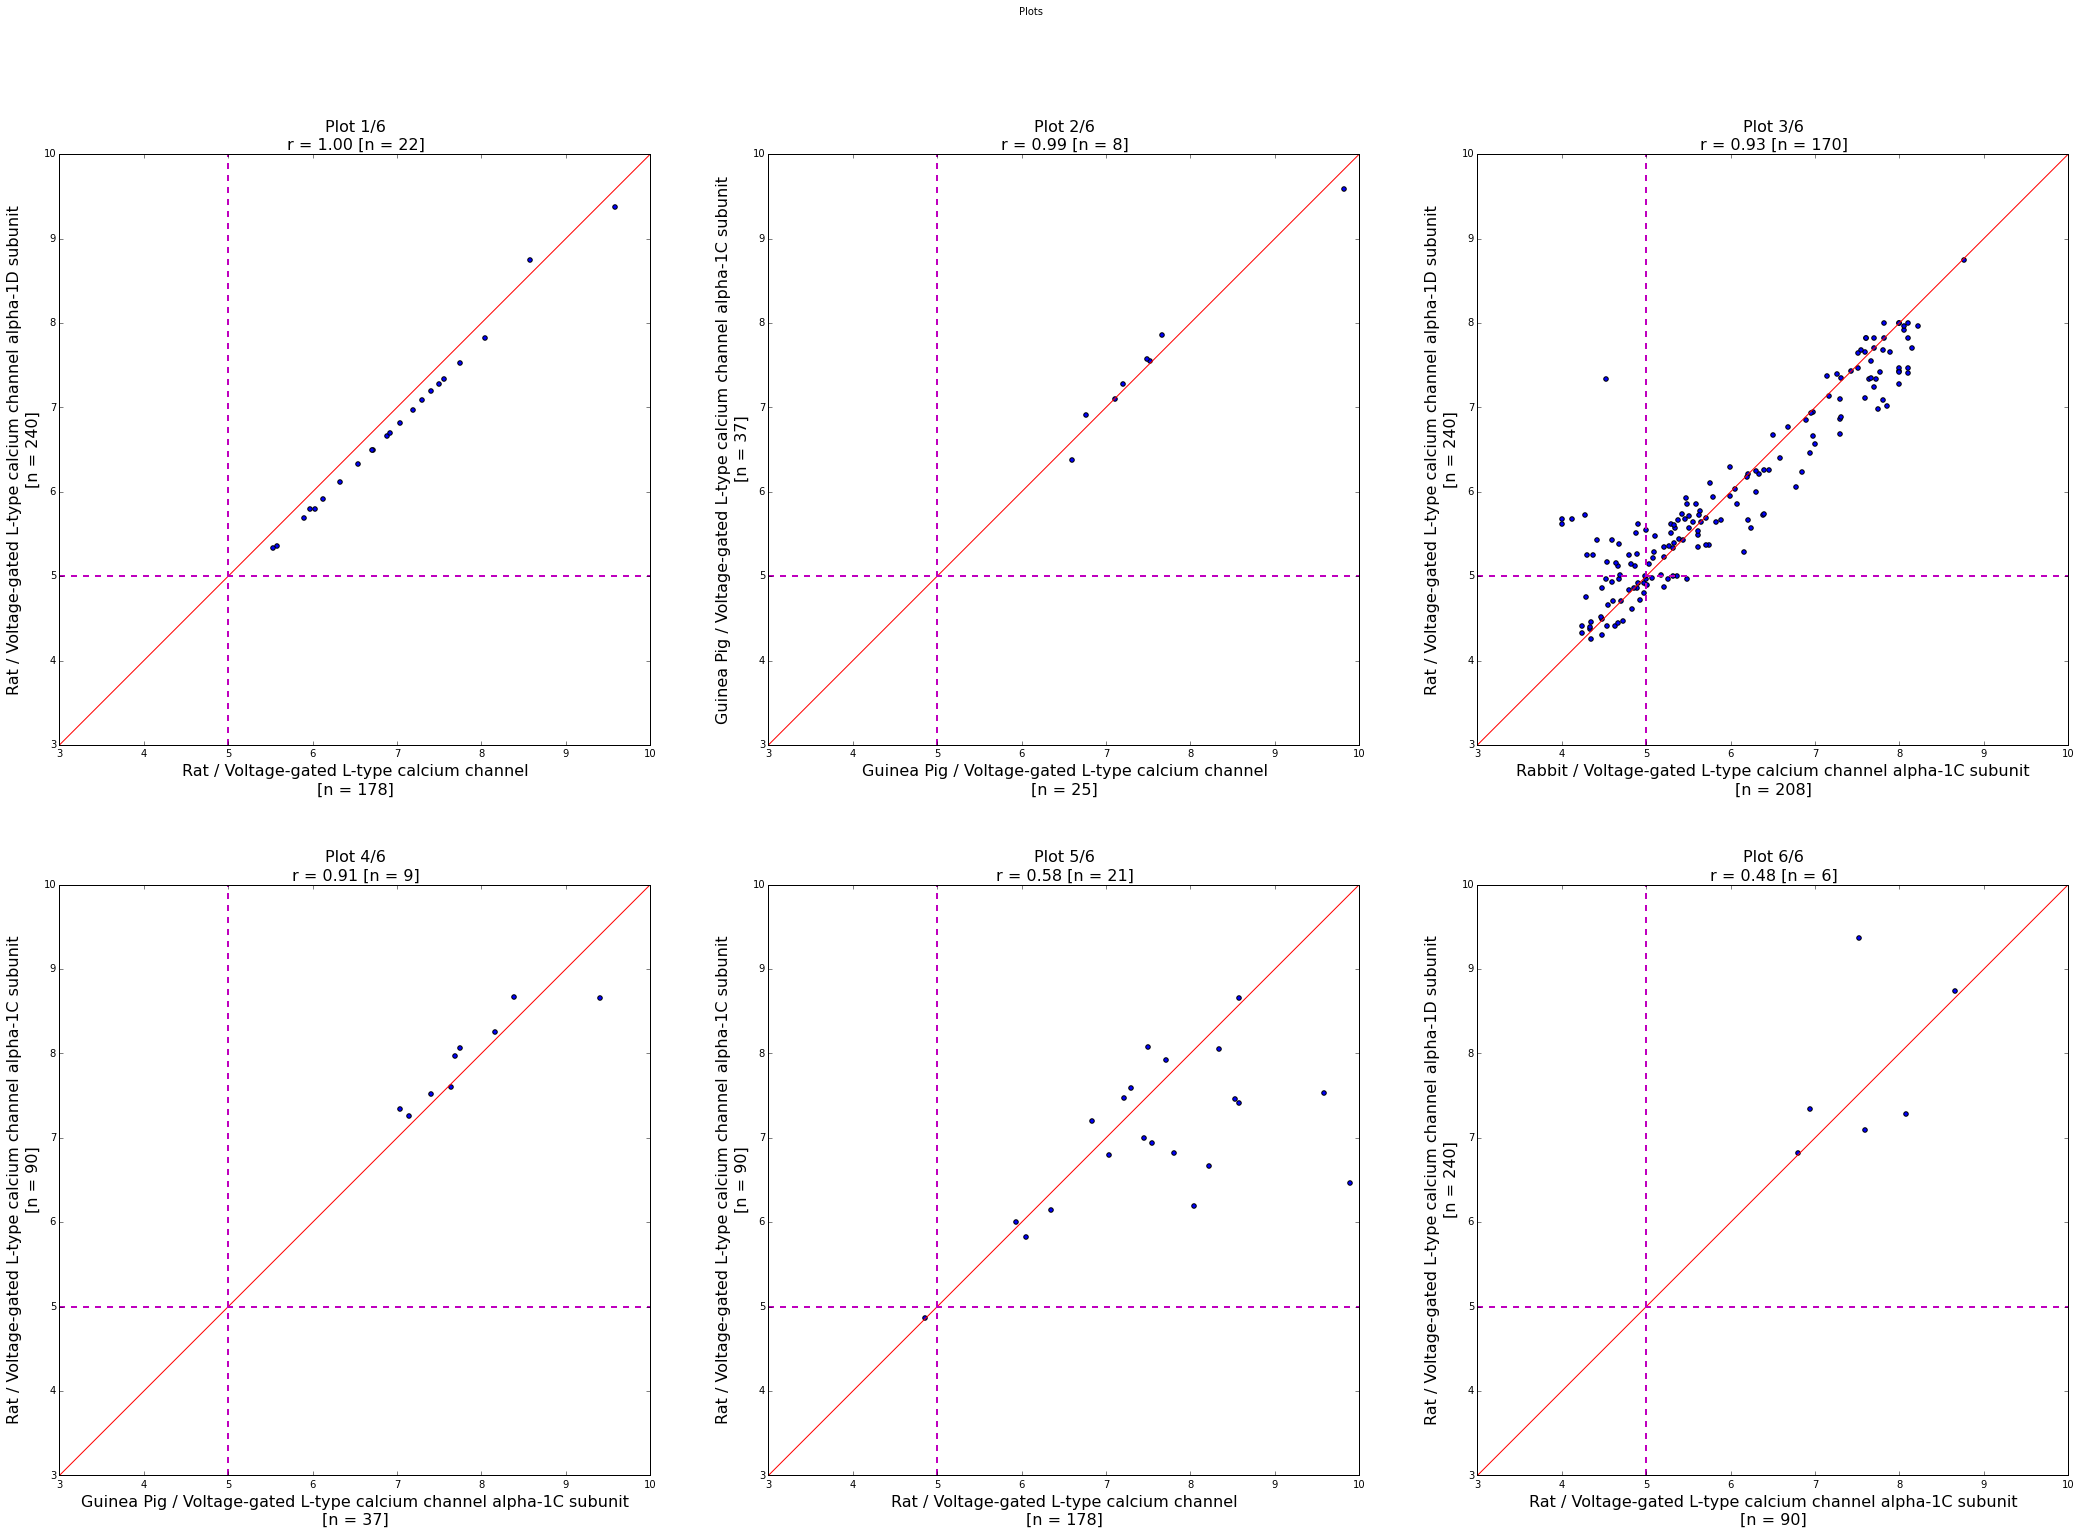

In [37]:
# Plot pActivity values for pairs of targets...

n_col, size = 3, 12

min_xc50, max_xc50 = 3.0, 10.0

n_pairs = target_pairs.shape[0]

n_row = int(ceil(n_pairs / n_col))

fig, axes = plt.subplots(n_row, n_col, figsize=(size*n_col, size*n_row))

fig.suptitle('Plots')

if n_row > 1: axes = list(chain.from_iterable(axes))

for ax in axes[n_pairs:]: ax.axis('off')

for i, row in enumerate(target_pairs.itertuples()):

    index, target_1, n_1, target_2, n_2, n, r = row

    axis = axes[i]

    pair_means = means[[target_1, target_2]].dropna(how='any')

    axis.scatter(pair_means[target_1], pair_means[target_2])

    axis.set_xlim(min_xc50, max_xc50)
    axis.set_ylim(min_xc50, max_xc50)
    axis.set_aspect(1)

    axis.set_title("{} {}/{}\nr = {:.2f} [n = {}]".format('Plot', i+1, n_pairs, r, n), fontsize=16)
    axis.set_xlabel("{} / {}\n[n = {}]".format(target_1[0], target_1[1], n_1), fontsize=16)
    axis.set_ylabel("{} / {}\n[n = {}]".format(target_2[0], target_2[1], n_2), fontsize=16)

    axis.plot((min_xc50, max_xc50), (min_xc50, max_xc50), color='r', linestyle='-', linewidth=1)
    axis.plot((5, 5), (min_xc50, max_xc50), color='m', linestyle='--', linewidth=2)
    axis.plot((min_xc50, max_xc50), (5, 5), color='m', linestyle='--', linewidth=2)

* The degree of colinearity in the first plot is clearly an artifact, and is investigated as such [below](#collinearity).

* The second plot, for Gunea Pig 'Voltage-gated L-type calcium channel' _vs._ 'Voltage-gated L-type calcium channel alpha-1C subunit', apparently shows a high degree of agreement between these assays, which would rather contradict the suggestion made above that there is a systematic difference. This is investigated as further [below](#guinea_pig_data).

* he third plot apparently shows a reasonable correlation between Rabbit 'Voltage-gated L-type calcium channel alpha-1C subunit' and Rat 'Voltage-gated L-type calcium channel alpha-1D subunit' data. The significance of such a cross-species, cross-isoform correlation is not clear.

* The fourth plot shows a reasonable correlation for Guinea Pig and Rat 'Voltage-gated L-type calcium channel alpha-1C subunit', albeit only a fraction of compounds are in common. An analysis carried out in the same manner as that for the Guinea Pig [data]((#guinea_pig_data) from the second plot (not shows) suggests these compounds are again (with a one exception) isoxazole DHPs from a single publication (with different substituents, however)./ Again, whether the is real or an artifact resulting from how the assays were performed _etc._ is not clear.

* The last two plots show a lower degree of correlation, and no obvious conclusions can be drawn from them.

<a name="guinea_pig_data"></a>
### Guinea Pig data

The second plot, for Guinea Pig 'Voltage-gated L-type calcium channel' _vs._ 'Voltage-gated L-type calcium channel alpha-1C subunit', apparently shows a high degree of agreement between these assays, which would rather contradict the suggestion made above that there is a systematic difference. However, that there is good agreement for a subset of compounds does not necessarily preclude a significant overall difference.

Inspecting the compounds in the scatter plot shows that they are all but one (CHEMBL475534) from a particular subtype of DHP with an oxazole ring instaed of the more usual benzene ring...

In [38]:
# NB If plot is set to 4, the structures and source document for the compounds from the fourth plot may be inspected instead.

plot = 2

In [39]:
target_1, target_2 = target_pairs.iloc[plot-1][['target_1', 'target_2']]

pair_means = means[[target_1, target_2]].dropna(how='any')

pair_means.reset_index(inplace=True)

pair_means['image'] = pair_means['parent_cmpd_chemblid'].apply(lambda x: '<img src="https://www.ebi.ac.uk/chembl/api/data/image/{}?dimensions=250">'.format(x))

HTML(pair_means.to_html())

species,parent_cmpd_chemblid,Guinea Pig,Guinea Pig,image
pref_name,,Voltage-gated L-type calcium channel,Voltage-gated L-type calcium channel alpha-1C subunit,
0,CHEMBL2221282,7.52,7.55,
1,CHEMBL305903,7.66,7.86,
2,CHEMBL475534,9.82,9.59,
3,CHEMBL72620,7.20,7.28,
4,CHEMBL72717,7.11,7.10,
5,CHEMBL73647,6.76,6.91,
6,CHEMBL74944,7.48,7.57,
7,CHEMBL75770,6.60,6.38,


Furthermore, checking the documents from which these compounds come shows that all the data for the isoxazoles comes from one document, _i.e._ [CHEMBL1124881](https://www.ebi.ac.uk/chembl/doc/inspect/CHEMBL1124881), whereas the data for the non-isoxazole compound CHEMBL475534 comes from a disjoint set of publications...

In [40]:
parent_cmpd_chemblids = set(pair_means['parent_cmpd_chemblid'])

df = data.query("parent_cmpd_chemblid in @parent_cmpd_chemblids")[['parent_cmpd_chemblid', 'doc_chemblid']]

pd.crosstab(df['parent_cmpd_chemblid'], df['doc_chemblid'])

doc_chemblid,CHEMBL1123720,CHEMBL1124169,CHEMBL1124881,CHEMBL1125053,CHEMBL1125160
parent_cmpd_chemblid,,,,,
CHEMBL2221282,0,0,2,0,0
CHEMBL305903,0,0,2,0,0
CHEMBL475534,1,1,0,1,1
CHEMBL72620,0,0,2,0,0
CHEMBL72717,0,0,2,0,0
CHEMBL73647,0,0,2,0,0
CHEMBL74944,0,0,2,0,0
CHEMBL75770,0,0,2,0,0


Whether the isoxazole compounds described in document CHEMBL1124881 are unusual in their equipotence in the two tissues, whether there was something unusual about the assays described in the document or whether there are otrher factors that account for the apparent systematic difference in activities for the Guinea Pig assays described above is not yet clear.

<a name="collinearity"></a>
### Origins of suspicious colinearity in first plot

There apears to be colinearity in the the first plot, although there is an obvious offset.

Let us inspect the values involved...

In [41]:
plot = 1

target_1, target_2 = target_pairs.iloc[plot-1][['target_1', 'target_2']]

pair_means = means[[target_1, target_2]].dropna(how='any')

pair_means['diff'] = pair_means.apply(lambda x: round(x[target_1] - x[target_2], 2), axis=1)

pair_means

species,Rat,Rat,diff
pref_name,Voltage-gated L-type calcium channel,Voltage-gated L-type calcium channel alpha-1D subunit,
parent_cmpd_chemblid,,,
CHEMBL18988,8.045000,7.820,0.22
CHEMBL193,8.570000,8.745,-0.18
CHEMBL23,7.550000,7.340,0.21
CHEMBL24085,6.875000,6.660,0.21
CHEMBL24086,7.300000,7.090,0.21
CHEMBL24243,5.900000,5.690,0.21
CHEMBL24675,7.500000,7.280,0.22
CHEMBL26172,7.185000,6.970,0.22


Most values seem to differ by around 0.21 log units. To see what is going on we need to extract the raw data for these datapoints...

In [42]:
# Get the identifiers that index the raw data of interest...
    
species, pref_name = [set(x[i] for x in [target_1, target_2]) for i in [0, 1]]

subset_means = pair_means[abs(pair_means['diff'] - 0.21) < 0.02]

parent_cmpd_chemblid = set(subset_means.index.values)

In [43]:
# Subset the raw data for these targets...

subset_data = data.query("species in @species and pref_name in @pref_name and parent_cmpd_chemblid in @parent_cmpd_chemblid").sort(['parent_cmpd_chemblid', 'species', 'pref_name'])

In [44]:
# Inspect raw data...

col_subset = ['species', 'tissue', 'pref_name', 'assay_chemblid', 'description', 'parent_cmpd_chemblid', 'pchembl_value', 'activity_comment', 'data_validity_comment', 'potential_duplicate', 'compound_key', 'published_type', 'published_relation', 'published_value', 'published_units', 'doc_chemblid', 'pubmed_id', 'reference', 'active']

html = ''

for parent_cmpd_chemblid in subset_data['parent_cmpd_chemblid'].drop_duplicates():
    
    html += "<h4>{}</h4>".format(parent_cmpd_chemblid) \
        + subset_means.query("parent_cmpd_chemblid == @parent_cmpd_chemblid").to_html() \
        + subset_data.query("parent_cmpd_chemblid == @parent_cmpd_chemblid")[col_subset].to_html()
    
HTML(html)

Inspecting the raw data make it clear what has happened here...

An original MedChem paper ([CHEMBL1128175](https://www.ebi.ac.uk/chembl/doc/inspect/CHEMBL1128175)) reports both IC50 and (derived) K<sub>i</sub> values, and these data have been assigned the target 'Voltage-gated L-type calcium channel' by ChEMBL. A later, linked modelling paper ([CHEMBL1130013](https://www.ebi.ac.uk/chembl/doc/inspect/CHEMBL1130013)) then repeats the IC50 values, but this time they have been assigned the target 'Voltage-gated L-type calcium channel alpha-1D subunit'. 

This inconsistency in the target assignment explain why the same data have different targets; the (more-or-less) consistent offset is due to the averaging of an IC50 and the K<sub>i</sub> derived from it. This averaging of two redundant values is just a result of the preliminary nature of this analysis and could have been avoided by checking document identifiers and data types (_e.g._ IC50 _vs._ K<sub>i</sub>. However, it served to highlight an occurence of data duplication, which would not have been caught by the 'duplicate_data' flag in ChEMBL as the targets are different.

In [45]:
# CHEMBL1128175 and CHEMBL1130013...

HTML('<iframe src="http://pubs.acs.org/doi/pdf/10.1021/jm00022a005" height=500 width=800/> <iframe src="http://pubs.acs.org/doi/pdf/10.1021/jm9605647" height=500 width=800/>')